,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration
0,1,2022-05-01 00:00:36,2022-05-01 00:19:18,1.0,4.10,1.0,N,246,151,2,17.0,3.0,0.5,0.00,0.0,0.3,20.80,2.5,0.0,18.700000
1,1,2022-05-01 00:27:44,2022-05-01 00:41:33,1.0,2.30,1.0,N,238,74,2,11.0,3.0,0.5,0.00,0.0,0.3,14.80,2.5,0.0,13.816667
2,1,2022-05-01 00:59:00,2022-05-01 01:14:22,1.0,4.20,1.0,N,163,260,2,15.5,3.0,0.5,0.00,0.0,0.3,19.30,2.5,0.0,15.366667
3,1,2022-05-01 00:28:26,2022-05-01 00:37:49,1.0,1.60,1.0,N,238,75,1,7.5,3.0,0.5,2.25,0.0,0.3,13.55,2.5,0.0,9.383333
4,2,2022-04-30 23:53:47,2022-05-01 00:05:17,1.0,1.87,1.0,N,249,164,1,9.5,0.5,0.5,2.66,0.0,0.3,15.96,2.5,0.0,11.500000


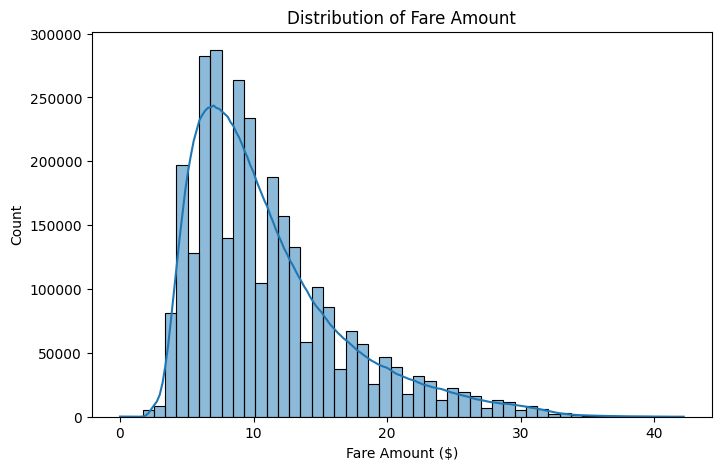

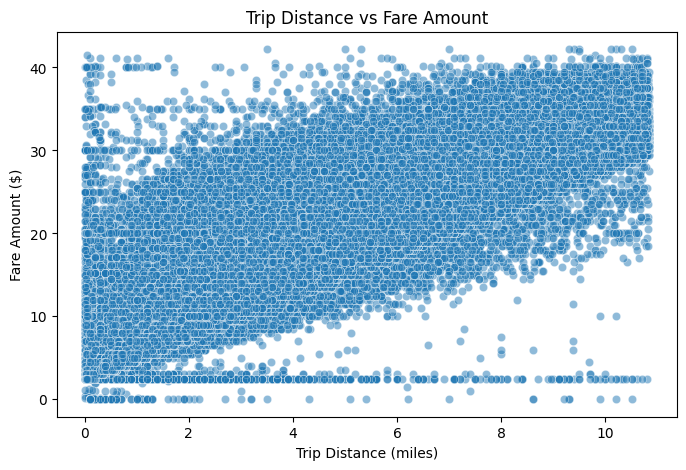

In [5]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned dataset
df = pd.read_parquet("../data/processed/yellow_processed_2022_05.parquet")

# Drop duplicates
df = df.drop_duplicates()

# Handling missing values
df = df.dropna()

# Check for negative or zero values in numerical columns
num_cols = ["fare_amount", "trip_distance", "total_amount", "passenger_count"]
for col in num_cols:
    if col in df.columns:
        df = df[df[col] > 0]

# Check for datetime inconsistencies
df["tpep_pickup_datetime"] = pd.to_datetime(df["tpep_pickup_datetime"])
df["tpep_dropoff_datetime"] = pd.to_datetime(df["tpep_dropoff_datetime"])
df = df[df["tpep_pickup_datetime"] < df["tpep_dropoff_datetime"]]

# Outlier detection using Z-score
z_thresh = 3  # 3 standard deviations from the mean
for col in ["fare_amount", "trip_distance", "total_amount"]:
    if col in df.columns:
        df = df[np.abs(stats.zscore(df[col])) < z_thresh]

# Ensure passenger count is reasonable (1-6 passengers for taxis)
if "passenger_count" in df.columns:
    df = df[(df["passenger_count"] >= 1) & (df["passenger_count"] <= 6)]

# Ensure pickup and dropoff locations are within valid NYC taxi zones
if "PULocationID" in df.columns and "DOLocationID" in df.columns:
    valid_zone_ids = range(1, 264)  # NYC Taxi zones range from 1 to 263
    df = df[df["PULocationID"].isin(valid_zone_ids) & df["DOLocationID"].isin(valid_zone_ids)]

# Display the cleaned dataset
display(df.head())

# Plot distribution of fare amount
plt.figure(figsize=(8, 5))
sns.histplot(df["fare_amount"], bins=50, kde=True)
plt.title("Distribution of Fare Amount")
plt.xlabel("Fare Amount ($)")
plt.ylabel("Count")
plt.show()

# Plot trip distance vs fare amount
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x="trip_distance", y="fare_amount", alpha=0.5)
plt.title("Trip Distance vs Fare Amount")
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Fare Amount ($)")
plt.show()


Summary Statistics:
        fare_amount  trip_distance  trip_duration  total_amount
count  3.333133e+06   3.333133e+06   3.333133e+06  3.333133e+06
mean   1.412325e+01   3.452722e+00   1.595794e+01  2.086771e+01
std    1.143909e+01   4.204458e+00   1.278773e+01  1.476279e+01
min    0.000000e+00   0.000000e+00   1.666667e-02  0.000000e+00
25%    7.000000e+00   1.150000e+00   7.633333e+00  1.230000e+01
50%    1.000000e+01   1.900000e+00   1.245000e+01  1.595000e+01
75%    1.600000e+01   3.520000e+00   1.996667e+01  2.256000e+01
max    6.400000e+01   4.380000e+01   1.789500e+02  8.309000e+01

Outlier Counts per Column (Z-score, IQR, Modified Z-score):
fare_amount: Z-score: 155692, IQR: 320147, Modified Z-score: 347448
trip_distance: Z-score: 145441, IQR: 412304, Modified Z-score: 428970
trip_duration: Z-score: 74836, IQR: 198525, Modified Z-score: 160601
total_amount: Z-score: 118955, IQR: 355850, Modified Z-score: 346646


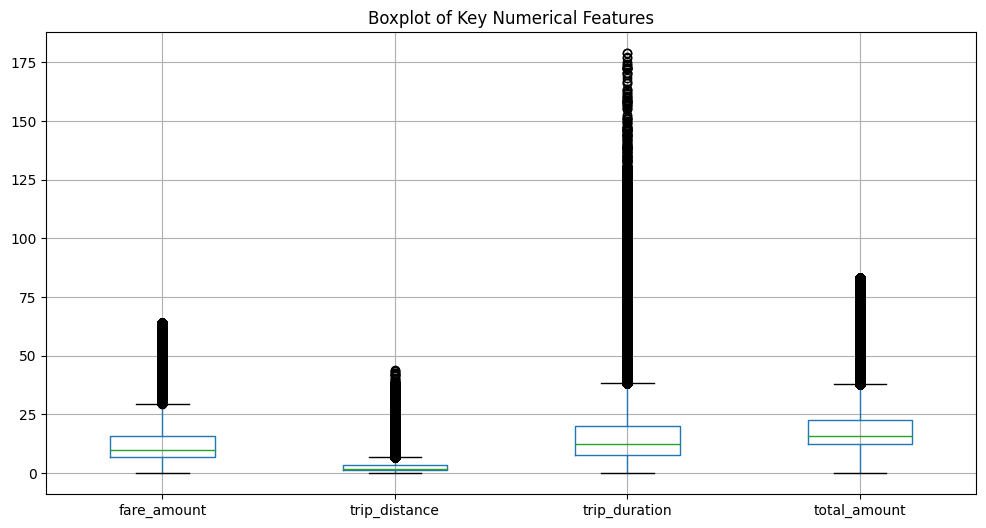

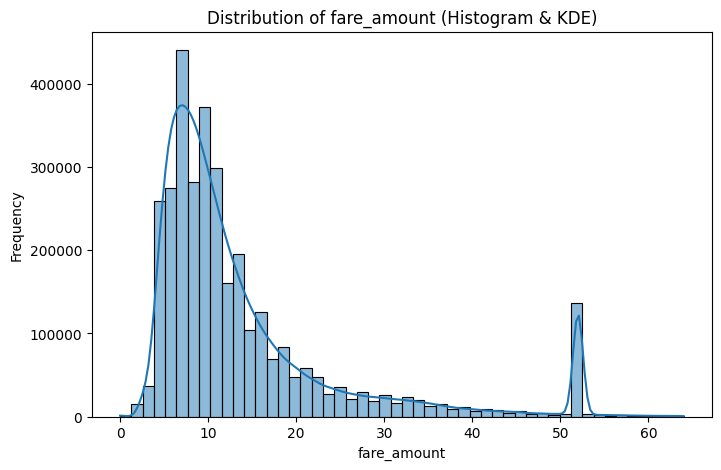

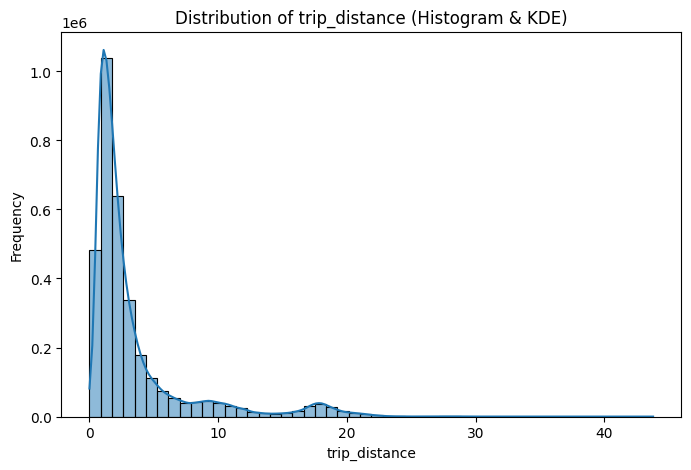

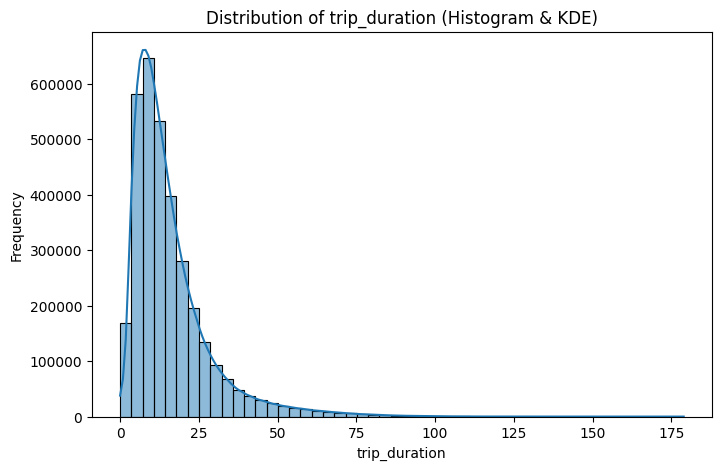

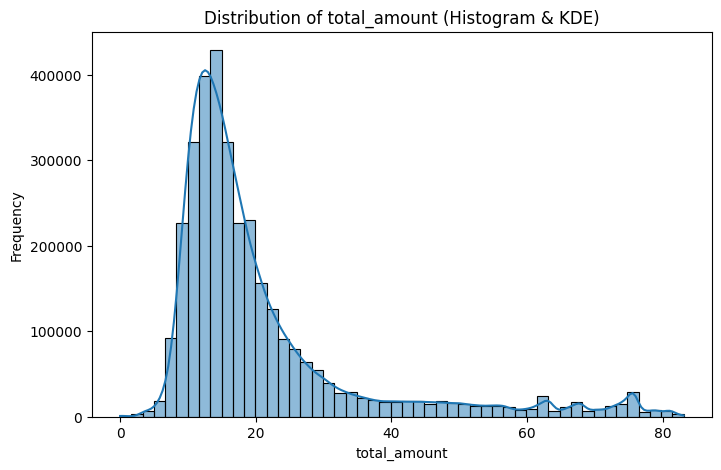

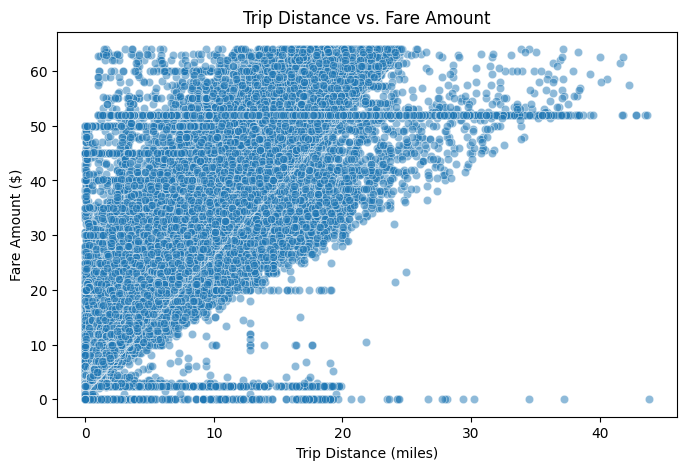

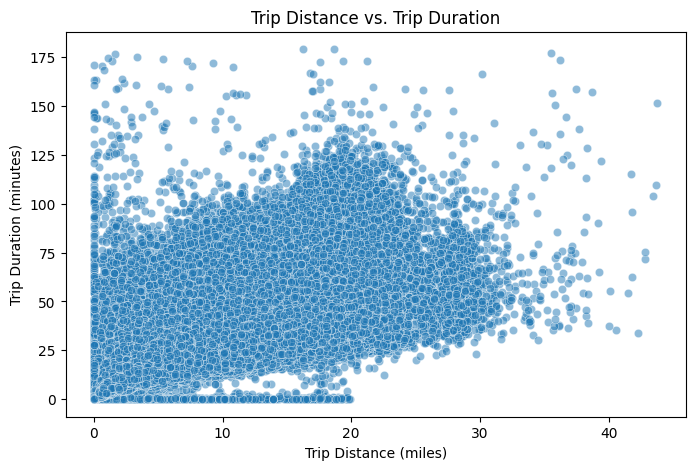

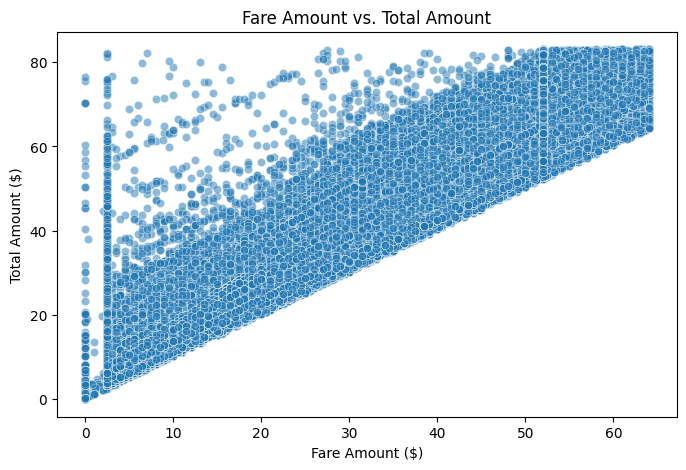

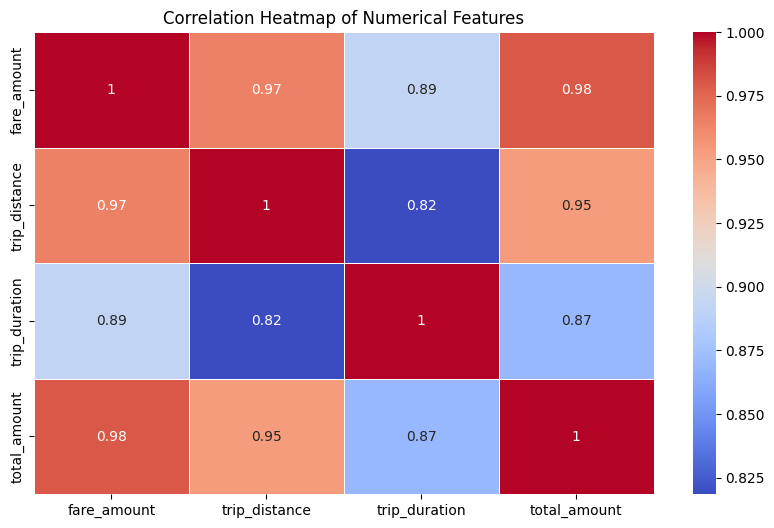

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Load the processed dataset
df = pd.read_parquet("../data/processed/yellow_processed_2022_05.parquet")

# Define numerical columns to check for outliers
numeric_cols = ["fare_amount", "trip_distance", "trip_duration", "total_amount"]

# Display the cleaned dataset
display(df.head())

# Display basic statistics
print("Summary Statistics:")
print(df[numeric_cols].describe())

# Detect outliers using Z-score method
def detect_outliers_zscore(df, column, threshold=3):
    z_scores = np.abs(stats.zscore(df[column]))
    return df[z_scores > threshold]

# Detect outliers using IQR (Interquartile Range)
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# Detect outliers using modified Z-score method (more robust to skewed data)
def detect_outliers_modified_zscore(df, column, threshold=3.5):
    median = df[column].median()
    mad = np.median(np.abs(df[column] - median))
    modified_z_scores = 0.6745 * (df[column] - median) / mad
    return df[np.abs(modified_z_scores) > threshold]

# Apply all methods to detect outliers
print("\nOutlier Counts per Column (Z-score, IQR, Modified Z-score):")
for col in numeric_cols:
    z_outliers = detect_outliers_zscore(df, col)
    iqr_outliers = detect_outliers_iqr(df, col)
    mod_z_outliers = detect_outliers_modified_zscore(df, col)
    
    print(f"{col}: Z-score: {len(z_outliers)}, IQR: {len(iqr_outliers)}, Modified Z-score: {len(mod_z_outliers)}")

# Visualizing outliers using boxplots
plt.figure(figsize=(12, 6))
df[numeric_cols].boxplot()
plt.title("Boxplot of Key Numerical Features")
plt.show()

# Visualizing distributions using histograms and KDE
for col in numeric_cols:
    plt.figure(figsize=(8, 5))
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(f"Distribution of {col} (Histogram & KDE)")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

# Scatter Plots to detect correlation-based anomalies
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x="trip_distance", y="fare_amount", alpha=0.5)
plt.title("Trip Distance vs. Fare Amount")
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Fare Amount ($)")
plt.show()

plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x="trip_distance", y="trip_duration", alpha=0.5)
plt.title("Trip Distance vs. Trip Duration")
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Trip Duration (minutes)")
plt.show()

plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x="fare_amount", y="total_amount", alpha=0.5)
plt.title("Fare Amount vs. Total Amount")
plt.xlabel("Fare Amount ($)")
plt.ylabel("Total Amount ($)")
plt.show()

# Heatmap to visualize correlations
plt.figure(figsize=(10, 6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()
